# Predicting House Sale Prices

We're going to look at predicting house sale prices from a selection of other features (to be determined), using linear regression (chosen due to continuous numeric nature of target variable).

Current status: Best root mean squared error (averaged over 10 folds) achieved so far: 28,942 (vs a target column mean of ~180k). Model not yet tested against the held back test dataset.

## Reading the data

Tab delimited file available from https://ww2.amstat.org/publications/jse/v19n3/decock/AmesHousing.txt with data dictionary https://ww2.amstat.org/publications/jse/v19n3/decock/DataDocumentation.txt.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import  LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score
%matplotlib inline

data = pd.read_csv('https://ww2.amstat.org/publications/jse/v19n3/decock/AmesHousing.txt',delimiter='\t')

data.head()


,Order,PID,MS SubClass,MS Zoning,Lot Frontage,Lot Area,Street,Alley,Lot Shape,Land Contour,...,Pool Area,Pool QC,Fence,Misc Feature,Misc Val,Mo Sold,Yr Sold,Sale Type,Sale Condition,SalePrice
0,1,526301100,20,RL,141.0,31770,Pave,NaN,IR1,Lvl,...,0,NaN,NaN,NaN,0,5,2010,WD,Normal,215000
1,2,526350040,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,...,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal,105000
2,3,526351010,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,...,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal,172000
3,4,526353030,20,RL,93.0,11160,Pave,NaN,Reg,Lvl,...,0,NaN,NaN,NaN,0,4,2010,WD,Normal,244000
4,5,527105010,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,...,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal,189900


We need to break up our data into a training and test set. We do this early so that we have a test set which hasn't influenced feature transformation and selection decisions. We do need to apply the same transformations to the test set though.

In [2]:
from sklearn.model_selection import train_test_split

# Shuffles by default, uses np.random by default. Test is 25% of original.
np.random.seed(1)
train, test = train_test_split(data)


## Pipeline version of process
### Transform > Select > Train and test

These three cells (will) contain the whole pipeline packaged into functions, to allow quick reuse. If you are reading this notebook for the first time, it's probably worth reading the third cell in this section, which contains the cross validation test function which I'll use to test models as I go, but otherwise skip to the cells below.

In [3]:
def transform_features(trainset,testset):
    
    # Give new names to preserve originals
    t_train, t_test = trainset, testset
    
    # Apply transformation to both sets, so we'll stick them in a list.
    frames = [t_train,t_test]
    
    for f in frames:
    
        # Remove columns with more than 25% of values missing
        f = f.drop(['Alley','Fireplace Qu','Pool QC','Fence','Misc Feature'],axis=1)
        
        # PID (postal id) and Order (observation number) aren't predictive. The others here leak info.
        f = f.drop(['PID','Order','Sale Type','Sale Condition','Mo Sold','Yr Sold'],axis=1)
        
    
        # Turning off chained assignment warning for the next step
        pd.options.mode.chained_assignment = None  # default='warn'
        
        # Selecting columns numeric columns
        cols = f.select_dtypes(include=['float64']).columns.tolist()
        # Fillna on selected columns
        f[cols] = f[cols].fillna(f[cols].mean())
        
        
        # Removing nominal columns with high proportion of nulls.
        f = f.drop(['Street', 'Land Contour', 'Condition 2', 'Roof Matl', 'Heating', 'Central Air'],axis=1)
        
        # Filling nulls for nominal columns from which I want to create dummies.
        f['Garage Type'].fillna('None',inplace=True)
        f['Mas Vnr Type'].fillna('Unknown',inplace=True)
        
        # Creating dummies of nominals and ordinals with no obvious maps
        cols = ['MS SubClass', 'MS Zoning', 'Lot Config', 'Neighborhood', 'Condition 1', 'Bldg Type', 'House Style',
                'Roof Style', 'Exterior 1st', 'Exterior 2nd', 'Mas Vnr Type', 'Foundation', 'Garage Type','Lot Shape',
                'Bsmt Exposure','BsmtFin Type 1','BsmtFin Type 2','Electrical','Functional','Garage Finish','Paved Drive']

        
        # Change to category type
        for c in cols:
            f[c] = f[c].astype('category')

        # Get dummy cols and combine to dataset
        dummy_cols = pd.get_dummies(f[cols])
        f = pd.concat([f,dummy_cols],axis=1)
        # Drop the original columns
        f.drop(cols,axis=1,inplace=True)
        
        # Drop ordinals that are largely one value
        f = f.drop(['Garage Qual','Garage Cond','Bsmt Cond','Utilities','Land Slope'],axis=1)

        # Map convenient ordinals to values
        m_vals = {'Ex':5,'Gd':4,'TA':3,'Fa':2,'Po':1,np.nan:0}
        cols = ['Exter Qual','Exter Cond','Bsmt Qual','Heating QC','Kitchen Qual']
        f[m_cols] = f[cols].applymap(m_vals.get)
    
    return t_train, t_test

In [4]:
def select_features(in_df):
    selected_train = in_df[['Gr Liv Area','SalePrice']] 
    return selected_train

In [5]:
# This will cross validate on the training set and return the rmse for each fold and the average.
def train_and_test(trainin,features,target='SalePrice',kf=10):
    lrm = LinearRegression()
    #train_data = select_features(inframe)
    
    mean_s_errors = cross_val_score(lrm,
                                    trainin[features],
                                    trainin[target],
                                    scoring='neg_mean_squared_error',
                                    cv=kf)
    # Root mean squared errors for each fold
    r_ms_errors = [abs(m)**(1/2) for m in mean_s_errors]
    
    # Average root mean squared error across all folds
    avg_rms_error = np.mean(r_ms_errors)
    
    return r_ms_errors, avg_rms_error

# Exploratory Cells

## Transformations

### Numerical nulls and data leaks 

In [6]:
# First looking for features with large numbers of nulls (more than 25%)
# We'll remove these wholesale, assuming nothing too vital jumps out.

num_val_counts = train.isnull().sum()
num_val_counts[num_val_counts > 0.25*train.shape[0]]

Alley           2054
Fireplace Qu    1066
Pool QC         2185
Fence           1778
Misc Feature    2117
dtype: int64

In [7]:
# Looks ok, so dropping these. Starting new set for transformed data, in case we want to check data again.
t_train = train[num_val_counts[num_val_counts < 0.25*train.shape[0]].index]

In [8]:
# Reassign to drop the four missing columns
num_val_counts = t_train.isnull().sum()

# Now we'll take a look at columns with fewer but still non-zero nulls.
t_train[num_val_counts[num_val_counts > 0].index].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2197 entries, 533 to 1061
Data columns (total 22 columns):
Lot Frontage      1835 non-null float64
Mas Vnr Type      2175 non-null object
Mas Vnr Area      2175 non-null float64
Bsmt Qual         2130 non-null object
Bsmt Cond         2130 non-null object
Bsmt Exposure     2128 non-null object
BsmtFin Type 1    2130 non-null object
BsmtFin SF 1      2196 non-null float64
BsmtFin Type 2    2129 non-null object
BsmtFin SF 2      2196 non-null float64
Bsmt Unf SF       2196 non-null float64
Total Bsmt SF     2196 non-null float64
Electrical        2196 non-null object
Bsmt Full Bath    2196 non-null float64
Bsmt Half Bath    2196 non-null float64
Garage Type       2077 non-null object
Garage Yr Blt     2075 non-null float64
Garage Finish     2075 non-null object
Garage Cars       2196 non-null float64
Garage Area       2196 non-null float64
Garage Qual       2075 non-null object
Garage Cond       2075 non-null object
dtypes: float64(11), o

From the data dictionary we can see all the numeric columns here are ordinal or continuous, so we can replace nulls in these columns with the mean for the column without creating nonsense values.

In [9]:
# Turning off chained assignment warning
pd.options.mode.chained_assignment = None  # default='warn'

# Select columns to replace
cols = t_train.select_dtypes(include=['float64']).columns.tolist()

# Fillna on selected columns
t_train[cols] = t_train[cols].fillna(t_train[cols].mean())

t_train.head()

,Order,PID,MS SubClass,MS Zoning,Lot Frontage,Lot Area,Street,Lot Shape,Land Contour,Utilities,...,Enclosed Porch,3Ssn Porch,Screen Porch,Pool Area,Misc Val,Mo Sold,Yr Sold,Sale Type,Sale Condition,SalePrice
533,534,531363010,20,RL,80.000000,9605,Pave,Reg,Lvl,AllPub,...,0,0,0,0,0,4,2009,WD,Normal,159000
802,803,906203120,20,RL,90.000000,14684,Pave,IR1,Lvl,AllPub,...,0,0,0,0,0,6,2009,WD,Normal,271900
955,956,916176030,20,RL,69.549319,14375,Pave,IR1,Lvl,NoSeWa,...,0,0,233,0,0,1,2009,COD,Abnorml,137500
459,460,528180130,120,RL,48.000000,6472,Pave,Reg,Lvl,AllPub,...,0,0,0,0,0,4,2009,WD,Normal,248500
486,487,528290030,80,RL,61.000000,9734,Pave,IR1,Lvl,AllPub,...,0,0,0,0,0,5,2009,WD,Normal,167000


We'll return to the string fields separately. Let's briefly take a diversion to remove columns that may leak info about the final sale (i.e. columns that contain data we won't have when making a prediction, like the Sale Month and Year). We'll drop all of these. Additionally, reading the documentation we can see that PID and Order are not going to be useful for us so we'll drop those too.

In [10]:
leak_cols = ['Sale Type','Sale Condition','Mo Sold','Yr Sold','PID','Order']
t_train = t_train.drop(leak_cols,axis=1)

We'll do a quick test creating a model using all the numeric fields and cross validating.

In [11]:
select_cols = t_train.select_dtypes(exclude=['object']).columns.tolist()
select_cols.remove('SalePrice')
rmses, avg_rmse = train_and_test(t_train,select_cols)
print(avg_rmse,'\n',np.std(rmses))

36101.6369321 
 8283.43319608


So the number to beat is an avg_rmse of 36k (standard deviation of 8263).

### Nominal features

In [12]:
# Columns listed as nominal in the dictionary (minus those we've already dropped)
nominals = ['MS SubClass','MS Zoning','Street','Land Contour','Lot Config',
            'Neighborhood','Condition 1','Condition 2','Bldg Type','House Style',
            'Roof Style','Roof Matl','Exterior 1st','Exterior 2nd','Mas Vnr Type',
            'Foundation','Heating','Central Air','Garage Type']

# A couple of stats on each column. Also stored in dictionary.
noms = {}

for n in nominals:
    counts = t_train[n].value_counts(dropna=False)
    
    # Dictionary will contain % of rows belonging to the most common category
    noms[n] = [counts.max()/counts.sum(),counts.shape[0]]
    print(n,'\n % of rows with single value ',counts.max()/counts.sum(),'\n unique vals ',counts.shape[0],'\n')

MS SubClass 
 % of rows with single value  0.371415566682 
 unique vals  15 

MS Zoning 
 % of rows with single value  0.77560309513 
 unique vals  7 

Street 
 % of rows with single value  0.995903504779 
 unique vals  2 

Land Contour 
 % of rows with single value  0.902594446973 
 unique vals  4 

Lot Config 
 % of rows with single value  0.726900318616 
 unique vals  5 

Neighborhood 
 % of rows with single value  0.147473827947 
 unique vals  28 

Condition 1 
 % of rows with single value  0.862084660901 
 unique vals  9 

Condition 2 
 % of rows with single value  0.989986345016 
 unique vals  8 

Bldg Type 
 % of rows with single value  0.826126536186 
 unique vals  5 

House Style 
 % of rows with single value  0.511151570323 
 unique vals  8 

Roof Style 
 % of rows with single value  0.789713245335 
 unique vals  6 

Roof Matl 
 % of rows with single value  0.985889849795 
 unique vals  8 

Exterior 1st 
 % of rows with single value  0.359581247155 
 unique vals  16 

Exterio

Columns where a high number of rows have the same value won't have much use in the model, so can probably be discounted. We'll drop those here. I'm picking a threshold of 90% here.

In [13]:
print(t_train.shape)
for n in noms:
    if noms[n][0] > 0.9:
        print(n)
        # Drop from our transformed data and also from nominals list
        t_train.drop(n,axis=1,inplace=True)
        nominals.remove(n)
print(t_train.shape)

(2197, 71)
Street
Land Contour
Condition 2
Roof Matl
Heating
Central Air
(2197, 65)


Next we'll think about whether or not we want to transform the other nominal columns into dummy numerical columns. Scanning back over the list a few cells up, there are a few columns with a number of categories but they tend to be fairly important. The numbers aren't in the hundreds, so I'm inclined to keep them all. We do need to deal with nulls though, as null values throw an error when we try to change it to a category.

In [14]:
t_train[nominals].isnull().sum()

MS SubClass       0
MS Zoning         0
Lot Config        0
Neighborhood      0
Condition 1       0
Bldg Type         0
House Style       0
Roof Style        0
Exterior 1st      0
Exterior 2nd      0
Mas Vnr Type     22
Foundation        0
Garage Type     120
dtype: int64

In [15]:
t_train['Garage Type'].value_counts(dropna=False)

Attchd     1318
Detchd      568
BuiltIn     137
NaN         120
Basment      28
2Types       17
CarPort       9
Name: Garage Type, dtype: int64

In [16]:
t_train['Mas Vnr Type'].value_counts(dropna=False)

None       1307
BrkFace     658
Stone       190
NaN          22
BrkCmn       19
CBlock        1
Name: Mas Vnr Type, dtype: int64

The data dictionary lists the NaN garage types as 'no garage'. I'm inclined to trust the dictionary, so I'll fill those with a string 'None'. For Mas Vnr Type, none is already an option and the dictionary doesn't mention nulls, so I'll replace those with Unknown.

In [17]:
t_train['Garage Type'].fillna('None',inplace=True)
t_train['Mas Vnr Type'].fillna('Unknown',inplace=True)

In [18]:
print(nominals)

['MS SubClass', 'MS Zoning', 'Lot Config', 'Neighborhood', 'Condition 1', 'Bldg Type', 'House Style', 'Roof Style', 'Exterior 1st', 'Exterior 2nd', 'Mas Vnr Type', 'Foundation', 'Garage Type']


In [19]:
# Change to category type
for n in nominals:
    t_train[n] = t_train[n].astype('category')

# Get dummy cols and combine to dataset
dummy_cols = pd.get_dummies(t_train[nominals])
t_train = pd.concat([t_train,dummy_cols],axis=1)

# Drop the original columns
t_train.drop(nominals,axis=1,inplace=True)

Let's include these and cross validate a model briefly. No particular reason to expect the model will be significantly better than before since we haven't done any real feature selection yet, I'm just curious how it's progressing.

In [20]:
select_cols = t_train.select_dtypes(exclude=['object']).columns.tolist()
select_cols.remove('SalePrice')
rmses, avg_rmse = train_and_test(t_train,select_cols)
print(avg_rmse,'\n',np.std(rmses))

32984.6562297 
 6880.50832026


That is a little better. Moving on.

### Ordinal string columns

String columns with a meaningful order will be turned mapped to numeric values, where I can reasonably decided on a mapping pattern. If I can't decide how to map the columns, I'll treat them in the same was as the nominal columns (change to categories and create dummies).

In [21]:
t_train.select_dtypes(include=['object']).columns.tolist()

['Lot Shape',
 'Utilities',
 'Land Slope',
 'Exter Qual',
 'Exter Cond',
 'Bsmt Qual',
 'Bsmt Cond',
 'Bsmt Exposure',
 'BsmtFin Type 1',
 'BsmtFin Type 2',
 'Heating QC',
 'Electrical',
 'Kitchen Qual',
 'Functional',
 'Garage Finish',
 'Garage Qual',
 'Garage Cond',
 'Paved Drive']

From the dictionary, eight of these columns use a standard scale of Excellent to Poor (5 steps - some with nulls where the property doesn't have the item rated).

In [22]:
cols = ['Exter Qual','Exter Cond','Bsmt Qual','Bsmt Cond','Heating QC','Kitchen Qual','Garage Qual','Garage Cond']

for c in cols:
    print('\n',c,' - Non-null values:',t_train[t_train[c].isnull() == False].shape[0])
    print(t_train[c].value_counts(dropna=False))


 Exter Qual  - Non-null values: 2197
TA    1321
Gd     760
Ex      91
Fa      25
Name: Exter Qual, dtype: int64

 Exter Cond  - Non-null values: 2197
TA    1922
Gd     218
Fa      46
Ex       8
Po       3
Name: Exter Cond, dtype: int64

 Bsmt Qual  - Non-null values: 2130
Gd     930
TA     929
Ex     198
Fa      71
NaN     67
Po       2
Name: Bsmt Qual, dtype: int64

 Bsmt Cond  - Non-null values: 2130
TA     1970
Gd       83
Fa       72
NaN      67
Po        3
Ex        2
Name: Bsmt Cond, dtype: int64

 Heating QC  - Non-null values: 2197
Ex    1126
TA     632
Gd     365
Fa      71
Po       3
Name: Heating QC, dtype: int64

 Kitchen Qual  - Non-null values: 2197
TA    1105
Gd     870
Ex     164
Fa      57
Po       1
Name: Kitchen Qual, dtype: int64

 Garage Qual  - Non-null values: 2075
TA     1957
NaN     122
Fa       93
Gd       18
Po        5
Ex        2
Name: Garage Qual, dtype: int64

 Garage Cond  - Non-null values: 2075
TA     1993
NaN     122
Fa       55
Po       13
Gd       

Garage Quality and Condition are both ~95% one value, with nulls being the second most common category. This means both offer very little to the model, so aren't likely worth transforming. Basement condiditon is similar. External condition is marginal but I'm inclined to include it as I feel it should have a noticable predictive effect.

For the others, I'll use a map to transform the categories into values. 5 = Excellent, 1 = Poor (null = 0).

In [23]:
t_train = t_train.drop(['Garage Qual','Garage Cond','Bsmt Cond'],axis=1)

m_vals = {'Ex':5,'Gd':4,'TA':3,'Fa':2,'Po':1,np.nan:0}
m_cols = ['Exter Qual','Exter Cond','Bsmt Qual','Heating QC','Kitchen Qual']

t_train[m_cols] = t_train[m_cols].applymap(m_vals.get)
print(t_train[m_cols].head())

     Exter Qual  Exter Cond  Bsmt Qual  Heating QC  Kitchen Qual
533           4           3          4           5             4
802           4           3          4           4             4
955           3           3          3           4             4
459           5           3          5           5             5
486           4           3          4           5             4


In [24]:
# Remaining few ordinal columns
cols = ['Lot Shape','Utilities','Land Slope','Bsmt Exposure','BsmtFin Type 1','BsmtFin Type 2',
        'Electrical','Functional','Garage Finish','Paved Drive']

for c in cols:
    print('\n',c,' - Non-null values:',t_train[t_train[c].isnull() == False].shape[0])
    print(t_train[c].value_counts(dropna=False))


 Lot Shape  - Non-null values: 2197
Reg    1389
IR1     737
IR2      60
IR3      11
Name: Lot Shape, dtype: int64

 Utilities  - Non-null values: 2197
AllPub    2194
NoSewr       2
NoSeWa       1
Name: Utilities, dtype: int64

 Land Slope  - Non-null values: 2197
Gtl    2091
Mod      93
Sev      13
Name: Land Slope, dtype: int64

 Bsmt Exposure  - Non-null values: 2128
No     1406
Av      325
Gd      227
Mn      170
NaN      69
Name: Bsmt Exposure, dtype: int64

 BsmtFin Type 1  - Non-null values: 2130
GLQ    664
Unf    644
ALQ    332
Rec    204
BLQ    179
LwQ    107
NaN     67
Name: BsmtFin Type 1, dtype: int64

 BsmtFin Type 2  - Non-null values: 2129
Unf    1871
Rec      76
LwQ      69
NaN      68
BLQ      52
ALQ      38
GLQ      23
Name: BsmtFin Type 2, dtype: int64

 Electrical  - Non-null values: 2196
SBrkr    2020
FuseA     131
FuseF      38
FuseP       6
Mix         1
NaN         1
Name: Electrical, dtype: int64

 Functional  - Non-null values: 2197
Typ     2037
Min2      58
M

I'm less comfortable applying a mapping to these categories, as it's less obvious how to weight each value. Instead, I will convert each to dummy variables, as I did with the nominal columns. I can revisit this later and see if I can get any better results. I will drop utilities and land slope though, due to overwhelming proportion of rows belonging to a single value.

In [25]:
t_train.drop(['Utilities','Land Slope'],axis=1,inplace=True)

ordinals = ['Lot Shape','Bsmt Exposure','BsmtFin Type 1','BsmtFin Type 2',
        'Electrical','Functional','Garage Finish','Paved Drive']

# Change to category type
for n in ordinals:
    t_train[n] = t_train[n].astype('category',errors='ignore')

# Get dummy cols and combine to dataset
dummy_cols = pd.get_dummies(t_train[ordinals])
t_train = pd.concat([t_train,dummy_cols],axis=1)

# Drop the original columns
t_train.drop(ordinals,axis=1,inplace=True)

Again, I'm curious how the model is progressing so I'm going to just run it again briefly.

In [26]:
select_cols = t_train.select_dtypes(exclude=['object']).columns.tolist()
select_cols.remove('SalePrice')
rmses, avg_rmse = train_and_test(t_train,select_cols)
print(avg_rmse,'\n',np.std(rmses))

31890.3350239 
 7177.49353512


### Less useful numerical features

The year columns aren't terribly useful as they stand. We'll transform them into Age based columns instead (using 2010 as the year we are counting from, as that is when the data was compiled).

In [27]:
year_cols = ['Year Built','Year Remod/Add','Garage Yr Blt']
labels = ['Age','Remod age','Garage age']

for i,y in enumerate(year_cols):
    t_train[labels[i]] = 2010 - t_train[y]
    
# We'll also make a 'Years to remodel' column
t_train['Yrs_to_remod'] = t_train['Year Remod/Add'] - t_train['Year Built']

# And remove the original columns
t_train.drop(year_cols,axis=1,inplace=True)

## Feature Selection

We'll start narrowing down the list of features by looking at the correlation with the target variable (SalePrice). We'll start with the cutoff of 0.3.

In [28]:
correlations = t_train.corr()
strong_corrs = correlations[correlations['SalePrice'].abs() > 0.3]['SalePrice']
strong_corrs

Lot Frontage            0.345279
Overall Qual            0.799928
Mas Vnr Area            0.510983
Exter Qual              0.696899
Bsmt Qual               0.606123
BsmtFin SF 1            0.439838
Total Bsmt SF           0.629031
Heating QC              0.446074
1st Flr SF              0.619164
Gr Liv Area             0.699675
Full Bath               0.547815
Kitchen Qual            0.677269
TotRms AbvGrd           0.486375
Fireplaces              0.485029
Garage Cars             0.644069
Garage Area             0.637406
Wood Deck SF            0.343644
Open Porch SF           0.320682
SalePrice               1.000000
MS SubClass_60          0.360903
Neighborhood_NoRidge    0.300183
Neighborhood_NridgHt    0.443334
Exterior 1st_VinylSd    0.315120
Exterior 2nd_VinylSd    0.311573
Mas Vnr Type_None      -0.407839
Mas Vnr Type_Stone      0.301593
Foundation_CBlock      -0.342742
Foundation_PConc        0.518854
Garage Type_Attchd      0.343667
Garage Type_Detchd     -0.370471
Bsmt Expos

Checking how this model performs.

In [31]:
select_cols = strong_corrs.index.tolist()
select_cols.remove('SalePrice')
rmses, avg_rmse = train_and_test(t_train,select_cols)
print(avg_rmse,'\n',np.std(rmses))

33794.1329704 
 6350.30390007


Interesting. That's a slightly worse fit than just using all the numerics, however the standard deviation is much lower. Possibly an indication that there was some overfitting on the model using all possible features (one or two very low rmse values could bring the average down but the higher standard deviation would still be high - might indicate it the model won't generalise as well to a fresh dataset). Maybe I set the threshold too high? I'll drop the threshold to 0.25p.

In [30]:
strong_corrs2 = correlations[correlations['SalePrice'].abs() > 0.25]['SalePrice']

select_cols = strong_corrs2.index.tolist()
select_cols.remove('SalePrice')
rmses, avg_rmse = train_and_test(t_train,select_cols)
print(avg_rmse,'\n',np.std(rmses),'\n\n')

strong_corrs3 = correlations[correlations['SalePrice'].abs() > 0.2]['SalePrice']

select_cols = strong_corrs3.index.tolist()
select_cols.remove('SalePrice')
rmses, avg_rmse = train_and_test(t_train,select_cols)
print(avg_rmse,'\n',np.std(rmses))

33263.192849 
 6363.94315462 


32528.8036359 
 6296.4934608


I'm going to put investigation of this factor on hold, and will use strong_corrs3 (threshold of 0.2) for the next part.

Now we'll look to reduce collinearity. Correlation matrix is very useful for that.

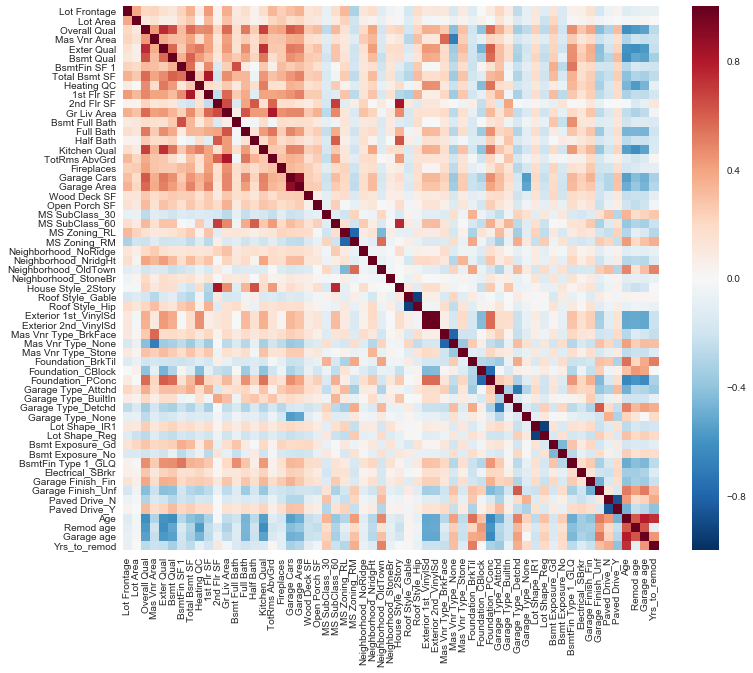

In [36]:
cols = strong_corrs3.index.tolist()
cols.remove('SalePrice')

fig,ax = plt.subplots(figsize=(12,10))
corrmat = t_train[cols].corr()
sns.heatmap(corrmat,ax=ax)

Quite a lot to pick through here. The first correlations that jump out are:
- External Qual - Overall Qual
- Bsmt Qual - Overall Qual
- Kitchen Qual - Overall Qual
- Age - Overall Qual
- 1st Floor SF - Total Bsmt SF
- Exterior 1st_VinylSd - Exterior 2nd_VinylSd
- TotRms AbvGrd - Gr Liv Area
- 1st Floor SF - Gr Liv Area
- Garage Cars - Garage Area

Since overall quality is covered by the individual quality measures, I'll first try leaving it out of the model. Exterior 2nd Vinyl is very strongly related to to the 1st on that column, so I'll leave that out too. Total Bsmt SF can go as well, as the 1st floor value is cleaner (didn't require null filling earlier). Gr Liv Area seems to cover TotRms AbvGrd and 1st Flr SF, while Garage Area should cover off Garage Cars (we're going to keep the continuous variable rather than the discrete one as it captures more information).

In [37]:
ignore = ['Overall Qual','Total Bsmt SF','Exterior 2nd_VinylSd','TotRms AbvGrd','SalePrice','1st Flr SF']
select_cols = strong_corrs3.drop(ignore).index.tolist()
strong_corrs3.drop(ignore)

Lot Frontage            0.345279
Lot Area                0.269321
Mas Vnr Area            0.510983
Exter Qual              0.696899
Bsmt Qual               0.606123
BsmtFin SF 1            0.439838
Heating QC              0.446074
2nd Flr SF              0.264890
Gr Liv Area             0.699675
Bsmt Full Bath          0.279429
Full Bath               0.547815
Half Bath               0.281398
Kitchen Qual            0.677269
Fireplaces              0.485029
Garage Cars             0.644069
Garage Area             0.637406
Wood Deck SF            0.343644
Open Porch SF           0.320682
MS SubClass_30         -0.242367
MS SubClass_60          0.360903
MS Zoning_RL            0.248080
MS Zoning_RM           -0.298562
Neighborhood_NoRidge    0.300183
Neighborhood_NridgHt    0.443334
Neighborhood_OldTown   -0.218327
Neighborhood_StoneBr    0.237375
House Style_2Story      0.213624
Roof Style_Gable       -0.257304
Roof Style_Hip          0.279516
Exterior 1st_VinylSd    0.315120
Mas Vnr Ty

In [38]:
# Rerun the model

rmses, avg_rmse = train_and_test(t_train,select_cols)
print(avg_rmse,'\n',np.std(rmses))

33625.9802669 
 6172.71564085


Well, that's the lowest standard deviation I've achieved so far. Not the lowest root mean squared error though.

I'm going to take a look at a few of the stronger correlated columns (to SalePrice) to poke around for outliers.

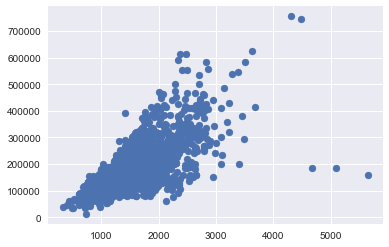

In [39]:
plt.scatter(t_train['Gr Liv Area'],t_train['SalePrice'])

There are a few outlier values here, down in the bottom right. Checking the rows that generate these (not pictured) shows them to be partial sales. I think I will drop these outliers prior to training my model (this is also advised in the data dictionary).

In [40]:
t_train = t_train[t_train['Gr Liv Area'] < 4500]

In [41]:
# Rerun the model
rmses, avg_rmse = train_and_test(t_train,select_cols)
print(avg_rmse,'\n',np.std(rmses))

28391.2055883 
 2823.41232965


That makes a really dramatic difference. Let's see if there are any others. The dictionary actually advises removing rows with Gr Liv Area below 4k. Lets see if that changes much.

In [42]:
# Rerun the model
rmses, avg_rmse = train_and_test(t_train[t_train['Gr Liv Area'] < 4000],select_cols)
print(avg_rmse,'\n',np.std(rmses))

27429.8859083 
 2335.06022593


Even better still. I'll remove those completely, then look at a few other highly correlated columns.

In [43]:
t_train = t_train[t_train['Gr Liv Area'] < 4000]

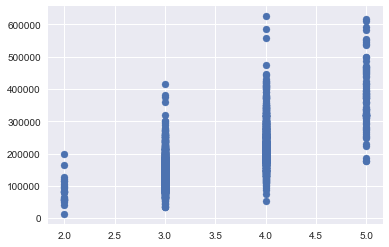

In [44]:
plt.scatter(t_train['Exter Qual'],t_train['SalePrice'])

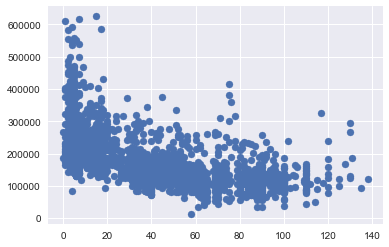

In [45]:
plt.scatter(t_train['Age'],t_train['SalePrice'])

Not seeing anything obvious that's worth pruning here. We've made a lot of progress but there are many more variations to try.

## Analysing the model

I'm going to do some analysis of the residuals and generally assess the goodness of fit of the model. First up, running the model and visualizing the residuals.

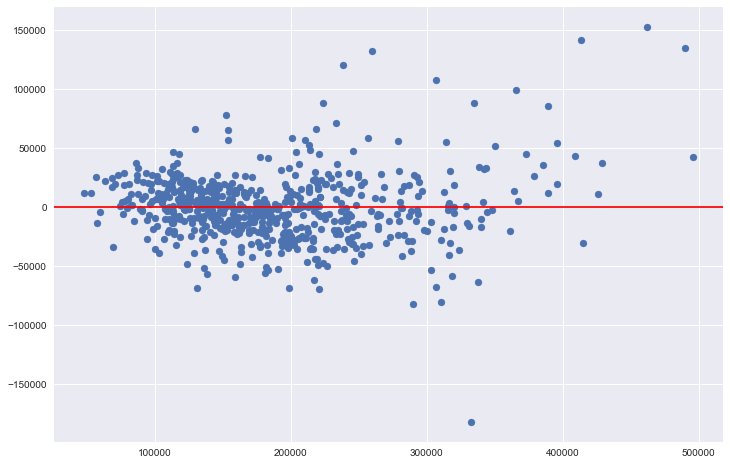

In [50]:
def model_residuals(df,features,target='SalePrice'):
    
    # Split the dataset into train and test.
    df_train = df[:int(df.shape[0]*0.7)]
    df_test = df[int(df.shape[0]*0.7):]
    
    # Start up a model
    lr = LinearRegression()
    
    # Fit the model, and return the predictions.
    lr.fit(df_train[features],df_train[target])
    fitted_values = lr.predict(df_test[features])
    residuals = df_test[target] - fitted_values
    
    return fitted_values, residuals, df_test[target]

fitted, residuals, actuals = model_residuals(t_train,select_cols)

fig,ax = plt.subplots(figsize=(12,8))
ax.scatter(fitted,residuals)
ax.axhline(c='red')

What we want to see here are residuals pretty evenly spread across the horizontal and verticle axes on this plot, i.e. we shouldn't be able to predict the error (the residual) from the fitted value. I would say that this looks pretty good overall.

Let's have a look at fitted values vs observed values.

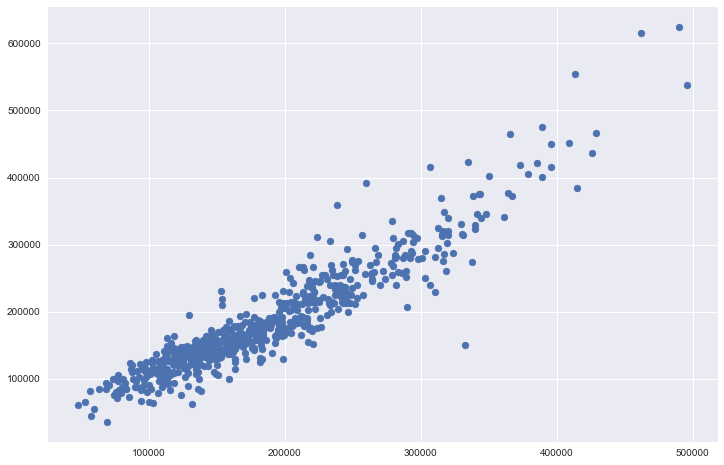

In [51]:
fig,ax = plt.subplots(figsize=(12,8))
ax.scatter(fitted,actuals)
#ax.axhline(c='red')

In [57]:
# Calculating R squared
SSres = np.sum(residuals**2)
SStot = np.sum((actuals - np.mean(actuals))**2)
R2 = 1 - SSres/SStot
print(SSres)
print(SStot)
print(R2)

529211322852.0168
4305530827696.021
0.8770856965074365


R^2 is fairly high, at 87.7%.

## Pure experiment

Just trying some things based on some kaggle kernels I read. Ignore this for the moment.

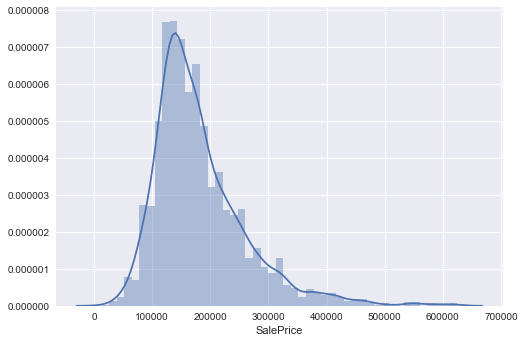

In [78]:
sns.distplot(t_train['SalePrice'])

SalePrice has positive skew. We may be able to improve model fit by transforming SalePrice to create a more normal target variable.

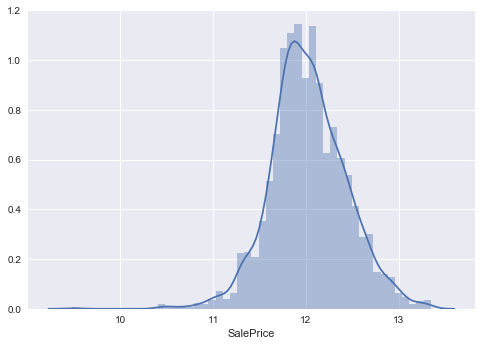

In [79]:
t = np.log(t_train['SalePrice'])
sns.distplot(t)

In [81]:
t_train['SalePriceLog'] = np.log(t_train['SalePrice'])

In [88]:
rmses, avg_rmse = train_and_test(t_train,select_cols,target='SalePriceLog')
print(rmses)
print(avg_rmse,'\n')
print(np.exp(avg_rmse))

[0.14977600728344709, 0.1364707943553517, 0.17729259640185444, 0.1309805207818053, 0.17675105681754855, 0.12234343805764269, 0.14873508989525006, 0.1382210580311517, 0.15258060734032433, 0.15035509867417071]
0.148350626764 

1.1599195239


In [83]:
t_train['SalePriceLog'].mean()

12.027057837942202